In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from paretoset import paretoset
import pickle

import pickle
import sys
sys.path.append('../')
sys.path.append('../usecase_cd')
sys.path.append('../src')
import src
import utils 
from plotting_tools import read_pkl_surrogate

plt.style.use("seaborn-v0_8-paper")

font = 16
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font,
    'axes.titlesize': font
})
import warnings
warnings.filterwarnings("ignore")

## Tutorial: Analysis of collected Pareto frontier 

This notebook serves as tutorial for analysing solutions for multiple-optimization objectives (=Pareto frontier).
1. We will look into how we can retrieve these solutions of a random 2D sample set.
2. We will investigate our smallest network topology, the (2,1)-tree.

### 1. Pareto front of a random 2D sample set 

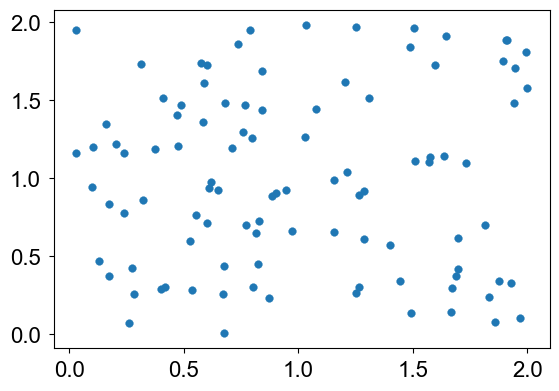

In [2]:
a = 0
b = 2
sample = (b-a) * np.random.random_sample((2,100)) + a
plt.scatter(x=sample[0], y=sample[1])
plt.show()

The Pareto frontier of the collected sample can be easiliy retrieved with `paretoset()` and is marked in orange below.

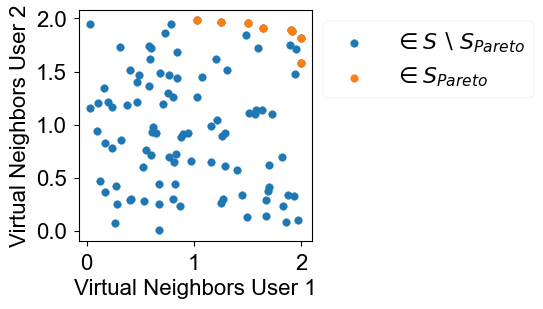

In [3]:
filter = paretoset(sample.T, sense=["max", "max"])
fig, ax = plt.subplots(figsize=[3,3])
plt.ylabel('Virtual Neighbors User 2')
plt.xlabel('Virtual Neighbors User 1')
plt.scatter(x=sample[0], y=sample[1], label=r'$\in S\setminus S_{Pareto}$')
plt.scatter(x=sample[0][filter], y=sample[1][filter], label=r'$\in S_{Pareto}$')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('simple-pareto.pdf', bbox_inches="tight")

### 2. Pareto analysis of (2,1)-tree of collected solution set

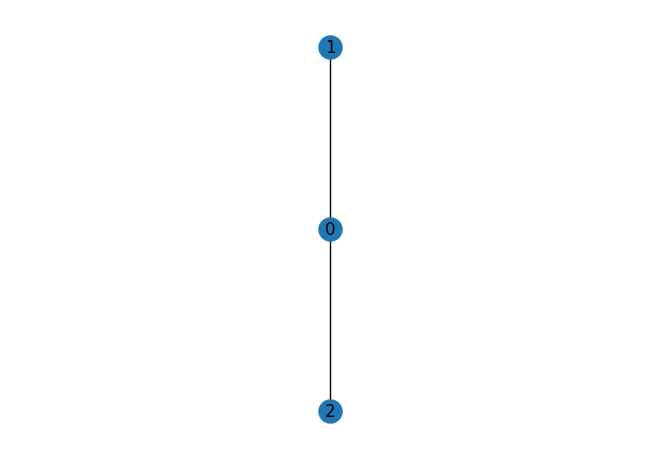

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(2, 1)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos, with_labels=True)
plt.show()

Load solution from `surdata` or run `sur.py --topo 2,1 --time 0.5` (30 min runtime). `config.py` is set with the following parameters

* 'protocol': 'ndsrs',
* 'p_gen': 0.9,
* 'p_swap': 1,
* 'return_data': 'avg',
* 'progress_bar': None,
* 'total_time': 1000,
* 'N_samples': 1000,
* 'p_cons': 0.225,
* 'qbits_per_channel': 5,
* 'cutoff': 28,
* 'M': 2,
* 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])

In [6]:
pd.read_csv('../../surdata/cd_tree-2-1_randtree-20/SU_tree-2-1_20iterator-vals.csv')

,protocol,ndsrs
0,p_gen,0.9
1,p_swap,1
2,return_data,avg
3,progress_bar,NaN
4,total_time,1000
5,N_samples,1000
6,p_cons,0.225
7,qbits_per_channel,5
8,cutoff,28
9,M,2


In [7]:
df = pd.read_csv('../../surdata/cd_tree-2-1_randtree-20/SU_tree-2-1_20iterator_objective-meanopt_SEED42_04-23-2024_17:56:17.csv')

In [8]:
# How to calculate which cutoff time to set (given total runtime T, M, Fnew and Fapp)
T = 1000
M = 4
Fnew = 0.888
Fapp = 0.6
-T*np.log( 3/(4*Fnew-1) * ((4*Fapp-1)/3)**(1/M) )

28.800089826157972

In [9]:
df

,Unnamed: 0,q_swap0,q_swap1,Iteration,0,1,2,0_std,1_std,2_std,0_raw,1_raw,2_raw,Simulation [s],Build [s],Acquisition [s],Total [s]
0,0,0.773956,0.975622,0,0.243243,1.123123,1.120120,0.758056,0.573218,0.570177,0.243243,1.123123,1.120120,56.34481,0.000262,0.000000,56.370023
1,1,0.438878,0.761140,0,0.978979,1.464464,1.470470,0.956033,0.706212,0.706489,0.978979,1.464464,1.470470,56.34481,0.000262,0.000000,56.370023
2,2,0.858598,0.786064,0,0.162162,1.085085,1.077077,0.675279,0.528212,0.516443,0.162162,1.085085,1.077077,56.34481,0.000262,0.000000,56.370023
3,3,0.697368,0.128114,0,0.380380,1.188188,1.190190,0.830589,0.625190,0.626459,0.380380,1.188188,1.190190,56.34481,0.000262,0.000000,56.370023
4,4,0.094177,0.450386,0,1.993994,1.302302,1.302302,0.316022,0.677684,0.677684,1.993994,1.302302,1.302302,56.34481,0.000262,0.000000,56.370023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,185,0.212054,0.411126,19,1.879880,1.638639,1.636637,0.647487,0.694604,0.693519,1.879880,1.638639,1.636637,73.94440,0.022374,0.038184,74.005920
186,186,0.213399,0.287551,19,1.856857,1.612613,1.613614,0.682320,0.697964,0.697797,1.856857,1.612613,1.613614,73.94440,0.022374,0.038184,74.005920
187,187,0.213363,0.279633,19,1.850851,1.611612,1.610611,0.688726,0.698129,0.698292,1.850851,1.611612,1.610611,73.94440,0.022374,0.038184,74.005920
188,188,0.213586,0.034887,19,1.859860,1.630631,1.638639,0.674180,0.694719,0.693105,1.859860,1.630631,1.638639,73.94440,0.022374,0.038184,74.005920


In [10]:
virtual_neighbours = df[['0','1','2']] # N = 1000
virtual_neighbours.columns = [f'User {i}' for i in range(3)]
virtual_neighbours = virtual_neighbours[['User 0', 'User 1', 'User 2']]
virtual_neighbours

,User 0,User 1,User 2
0,0.243243,1.123123,1.120120
1,0.978979,1.464464,1.470470
2,0.162162,1.085085,1.077077
3,0.380380,1.188188,1.190190
4,1.993994,1.302302,1.302302
...,...,...,...
185,1.879880,1.638639,1.636637
186,1.856857,1.612613,1.613614
187,1.850851,1.611612,1.610611
188,1.859860,1.630631,1.638639


In [11]:
vn = virtual_neighbours.to_numpy()
filter = paretoset(vn, sense=["max"]*3)
print(len(filter))

190


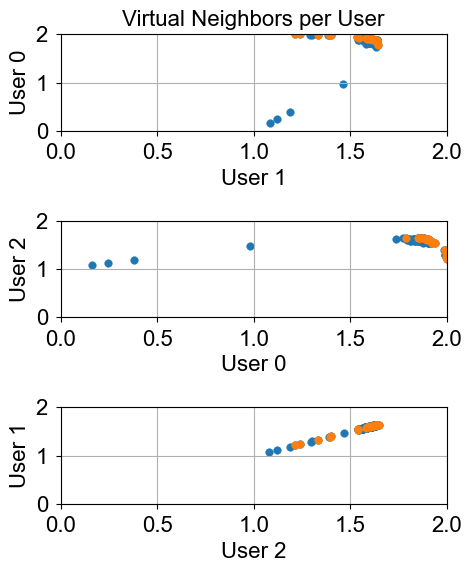

In [12]:
fig, axs = plt.subplots(3,sharey=False, sharex=False, figsize=[5,6])
labels = [1,0,2,1]
for i,ax in enumerate(axs):
    ax.scatter(x=vn[:,labels[i]], y=vn[:,labels[i+1]])
    ax.scatter(x=vn[:,labels[i]][filter], y=vn[:,labels[i+1]][filter])
    ax.set_xlabel(f'User {labels[i]}')
    ax.set_ylabel(f'User {labels[i+1]}')
    ax.set_ylim([0,2])
    ax.set_xlim([0,2])
    ax.grid()
axs[0].set_title('Virtual Neighbors per User')
plt.tight_layout()
plt.show()

In [13]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
virtual_neighbours['filter'] = filter
fig = px.scatter_3d(virtual_neighbours, x=virtual_neighbours.columns[0], y=virtual_neighbours.columns[1], z=virtual_neighbours.columns[2],
              color='filter')
plt.tight_layout()
fig.show()

<Figure size 640x440 with 0 Axes>

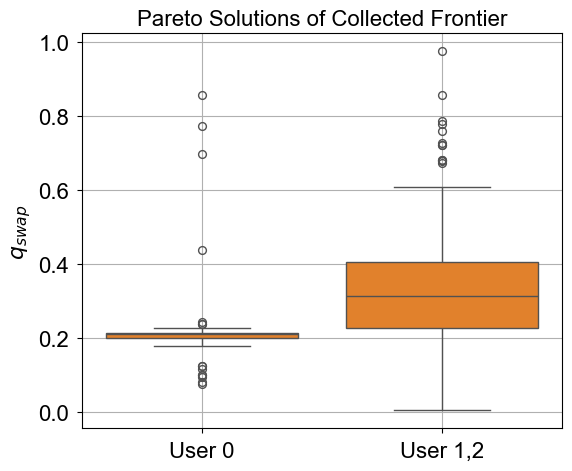

In [14]:
fig, ax = plt.subplots(figsize=(6,5))
g = sns.boxplot(df[df.columns[df.columns.str.contains('q_swap')]], palette=['tab:orange'])
g.set_xticklabels(['User 0', 'User 1,2'])
plt.ylabel(r'$q_{swap}$')
plt.title('Pareto Solutions of Collected Frontier')
plt.grid()
plt.tight_layout()
plt.savefig('cd-21tree-pareto.pdf')
plt.show()

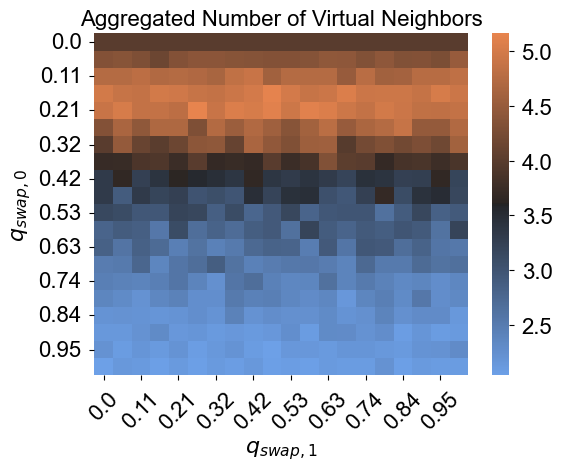

In [15]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
df_plot = pd.read_pickle('../usecase_cd/21tree-heatmap.pkl')
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_plot, cmap=cmap) #cbar_kws={'label': 'Aggregated Virtual Neighbors'}
plt.xlabel(r'$q_{swap,1}$')
plt.ylabel(r'$q_{swap,0}$')
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
plt.title('Aggregated Number of Virtual Neighbors')
plt.tight_layout()
plt.savefig('cd-21tree-heatmap.pdf')

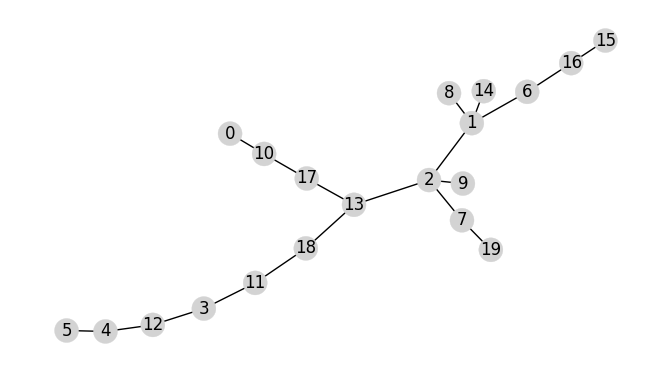

In [16]:
n=20
graph = nx.random_tree(n, seed=7)
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph-plain.pdf')

In [25]:
df = pd.read_csv('../../surdata/cd_tree-2-1_randtree-20/SU_randtree-20_0.05iterator_objective-meanopt_SEED42_05-01-2024_11:27:56.csv')
vn = df[df.columns[df.columns.str.fullmatch(r'\d+')]]
df_q = df[df.columns[df.columns.str.contains('q_swap')]]

In [26]:
vn

,0,1,2,3,4,5,6
0,1.578947,2.000000,2.000000,1.263158,2.157895,1.526316,1.526316
1,1.000000,1.578947,1.684211,1.894737,1.526316,1.789474,1.105263
2,1.368421,1.894737,1.842105,1.789474,1.842105,1.315789,2.157895
3,1.315789,1.789474,1.000000,1.842105,1.157895,1.105263,1.631579
4,2.315789,1.157895,1.368421,1.578947,1.526316,1.000000,1.684211
...,...,...,...,...,...,...,...
285,2.842105,2.526316,2.105263,2.105263,2.263158,1.736842,2.210526
286,2.736842,2.210526,2.736842,2.421053,1.947368,1.421053,2.789474
287,2.421053,2.157895,2.473684,2.578947,1.894737,1.631579,2.421053
288,2.368421,2.473684,2.052632,2.421053,2.105263,1.684211,2.263158


In [27]:
def get_pareto_frontier(vn, q_set, cluster = None):
    vn_to_analyse = vn if cluster == None else vn[cluster]
    filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
    return q_set[filter], sum(filter)

In [28]:
df_q_filtered, size = get_pareto_frontier(vn, df_q)
size

102

In [29]:
df_q_filtered.std()['q_swap15']

0.13863640671095795

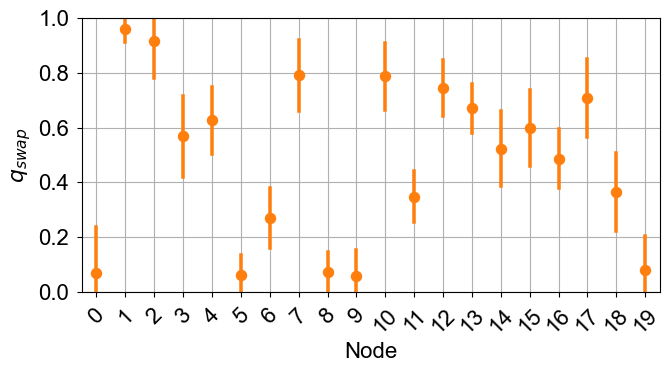

In [30]:
import re
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize = [7,4])
sns.pointplot(df_q_filtered, palette={'tab:orange'}, errorbar='sd', ax=ax)#{node: cmap(val) for node, val in dict(df_q_filtered.mean()).items()}, )
plt.xlabel('Node')
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto.pdf')

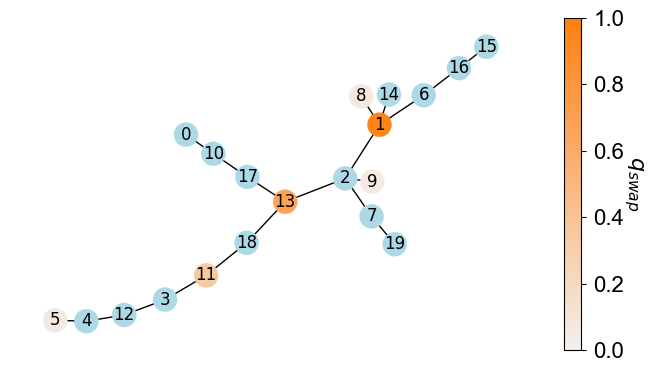

In [31]:
n=20
graph = nx.random_tree(n, seed=7)
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
for idx in labels:
    colors[int(idx)] = cmap(df_q_filtered['q_swap'+idx].mean()) if df_q_filtered['q_swap'+idx].std() <= 0.1 else 'lightblue'
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$q_{swap}$', labelpad=15, rotation=270)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph.pdf')

In [36]:
df = pd.read_csv('../../surdata/cd_randtree-100-10h/SU-randtree-100_10h.csv')
vn = df[df.columns[df.columns.str.fullmatch(r'\d+')]]
df_q = df[df.columns[df.columns.str.contains('q_swap')]]

In [37]:
vn

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.421053,2.210526,1.157895,1.263158,1.894737,1.789474,1.421053,1.315789,2.052632,1.421053,...,1.157895,1.842105,1.210526,1.894737,2.000000,1.210526,1.526316,1.157895,1.894737,1.105263
1,1.631579,1.263158,1.000000,2.052632,1.368421,1.631579,1.526316,1.210526,1.578947,1.263158,...,1.789474,1.052632,1.368421,2.052632,1.789474,2.052632,1.684211,1.736842,1.526316,1.578947
2,1.421053,1.842105,1.894737,1.526316,1.105263,1.578947,1.526316,2.000000,1.157895,1.210526,...,1.684211,1.210526,1.631579,1.578947,1.947368,1.789474,1.684211,1.526316,1.473684,0.842105
3,1.263158,1.315789,2.052632,1.947368,1.526316,1.473684,1.000000,1.631579,1.789474,1.473684,...,2.000000,1.473684,1.210526,1.105263,1.736842,1.578947,2.052632,1.578947,1.315789,1.526316
4,1.368421,1.157895,1.684211,1.315789,1.105263,1.052632,1.263158,1.421053,1.473684,1.263158,...,1.684211,1.368421,1.315789,1.473684,1.052632,1.789474,1.105263,1.947368,2.000000,1.263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9515,2.157895,2.578947,1.894737,2.210526,2.421053,2.210526,2.368421,2.526316,2.315789,1.736842,...,1.578947,1.894737,2.105263,2.000000,2.578947,2.368421,2.263158,2.157895,2.157895,1.526316
9516,1.947368,2.421053,2.210526,2.421053,2.368421,2.210526,2.157895,2.578947,2.368421,2.105263,...,1.842105,2.263158,2.105263,2.052632,2.473684,2.105263,2.315789,2.157895,2.157895,1.368421
9517,1.894737,1.947368,2.000000,2.421053,1.684211,2.000000,2.000000,2.526316,2.368421,1.684211,...,1.947368,2.000000,2.157895,2.000000,2.263158,2.105263,2.578947,2.263158,1.789474,2.263158
9518,1.947368,2.631579,2.526316,2.315789,2.210526,2.315789,1.947368,2.526316,1.736842,1.578947,...,1.736842,1.578947,2.473684,2.315789,2.000000,2.157895,2.210526,2.000000,1.631579,1.631579


In [38]:
df_q_filtered, size = get_pareto_frontier(vn, df_q)

In [39]:
df_q_filtered.std(axis=0)[df_q_filtered.std(axis=0) < 0.2]

q_swap7     0.167387
q_swap8     0.191519
q_swap31    0.190073
q_swap50    0.195117
q_swap74    0.160791
dtype: float64

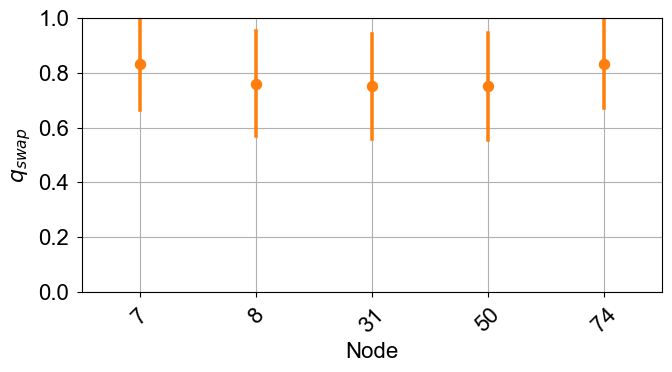

In [40]:
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize = [7,4])
sns.pointplot(df_q_filtered[df_q_filtered.columns[df_q_filtered.std(axis=0) < 0.2]], palette={'tab:orange'}, errorbar='sd', ax=ax)#{node: cmap(val) for node, val in dict(df_q_filtered.mean()).items()}, )
plt.xlabel('Node')
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('cd-random-tree100-pareto.pdf')

In [41]:
9207/9520

0.9671218487394958

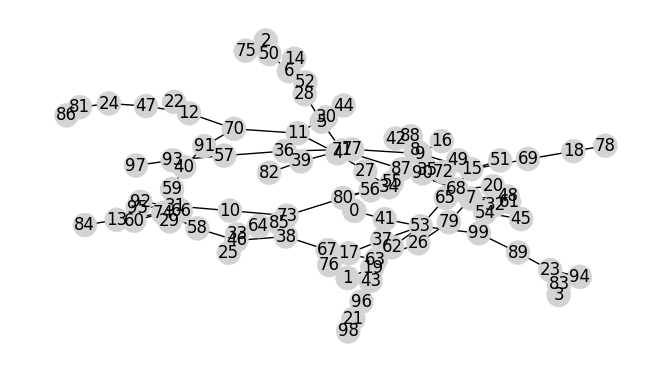

In [42]:
n=100
graph = nx.random_tree(n, seed=7)
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph-plain.pdf')

q_swap0     0.106753
q_swap1     0.073870
q_swap2     0.183184
q_swap3     0.038934
q_swap4     0.468381
              ...   
q_swap95    0.083468
q_swap96    0.629204
q_swap97    0.036317
q_swap98    0.369610
q_swap99    0.392892
Name: 9516, Length: 100, dtype: float64


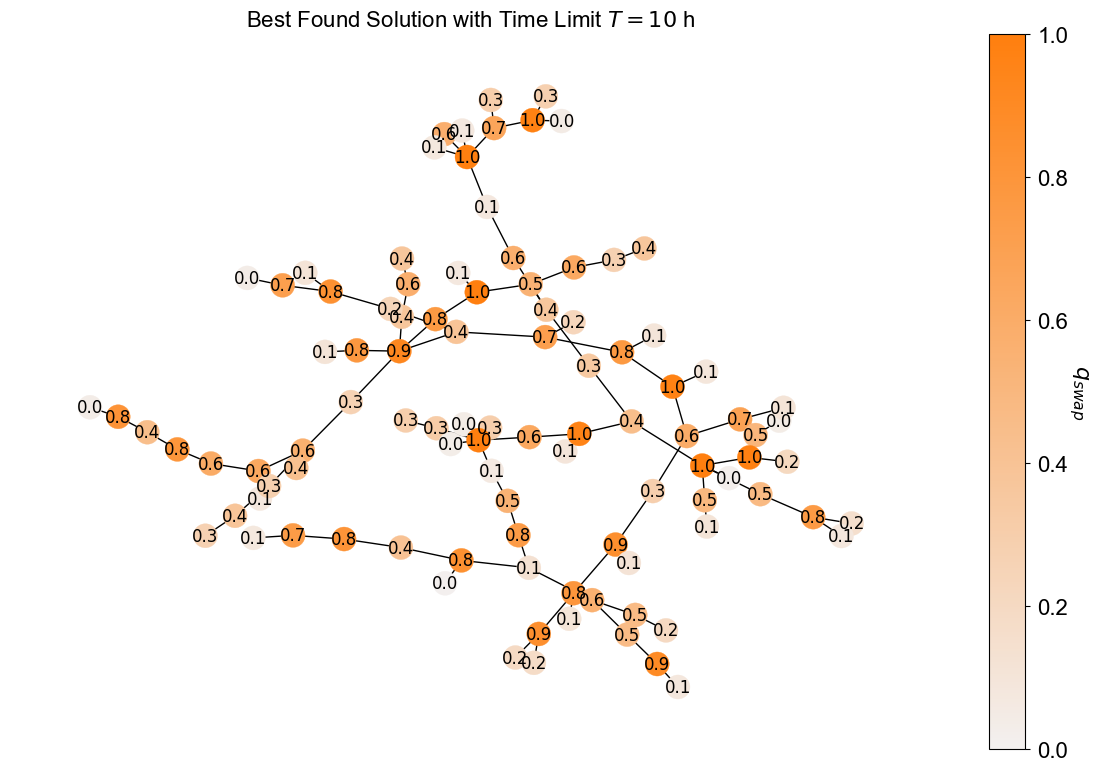

In [44]:
qvals = df_q.iloc[vn.sum(axis=1).argmax()]
print(qvals)
cmap =  sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors = [cmap(qswap_mean) for qswap_mean in qvals]
labels = {node: round(val,1) for node, val in enumerate(qvals)}
nx.draw(graph, pos, with_labels=False, node_color=colors, node_size=300)
nx.draw_networkx_labels(graph, pos, labels=labels)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.title(r'Best Found Solution with Time Limit $T = 10$ h')
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$q_{swap}$', labelpad=15, rotation=270)
plt.tight_layout()
plt.savefig('cd-random-tree-best.pdf')